# Mapping Post-Processing
Compress and sort the SAM file to BAM.  Remove duplicates and look at statistics

<hr >

## Current Directory Structure

In [1]:
%%bash
cd ./analysis
ls -1F

assembly/
data/
fastqc-analysis/
mappings/
trimmed/


- data: Raw FASTQ files
- trimmed: Sickle trimmed FASTQ files
- fastqc-analysis: FASTQC analysis of raw and trimmed FASTQ files
- assembly: reference genome assembly from ancestral genome with bowtie and bwa indexed references
- mappings: bowtie and bwa aligned mappings

<hr >

## Post processing with Samtools 
- Install samtools with conda
- Using samtools version 1.9

### SAM file format:

| Column        | Field         | Description  |
| ------------- |:-------------:|:-----:|
| 1 |QNAME  |Query (pair) NAME  |
| 2 |FLAG   |Bitwise FLAG  |
| 3 |RNAME  |Reference sequence NAME  |
| 4 |POS    |1-based leftmost Position/coordinate of clipped sequence  |
| 5 |MAPQ   |Mapping Quality (Phred-scaled)  |
| 6 |CIAGR  |Extended CIGAR string  |
| 7 |MRNM   |Mate Reference sequence name (‘=’ if same as RNAME)|
| 8 |MPOS   |1-based Mate Position  |
| 9 |ISIZE  |Inferred insert SIZE  |
| 10|SEQ    |Query Sequence on the same strand as the reference  |
| 11|QUAL   |Query Quality (ASCII-33 gives the Phred base quality) |
| 12|OPT    |variable Optional fields in the format TAG: VTYPE: VALUE  |

<hr >

## Fix Mates and Compress
- Clean up read pairing information and flags with SAMtools. 
- Compress SAM to BAM for efficient storing
- Use samtools sort -n to sort by name, as Samtools fixmate expects name-sorted input files
    - -m: Add ms (mate score) tags. These are used by markdup to select the best reads to keep.
    - -O bam: specifies compressed bam output from fixmate

#### Look at header of BAM file (Sorted by Query Name):

In [3]:
%%bash
samtools view -h analysis/mappings/bwa/evolved-6.fixmate.bam | head

@HD	VN:1.6	SO:queryname
@SQ	SN:NODE_1_length_1394677_cov_15.3771	LN:1394677
@SQ	SN:NODE_2_length_1051867_cov_15.4779	LN:1051867
@SQ	SN:NODE_3_length_950567_cov_15.4139	LN:950567
@SQ	SN:NODE_4_length_925223_cov_15.3905	LN:925223
@SQ	SN:NODE_5_length_916389_cov_15.4457	LN:916389
@SQ	SN:NODE_6_length_772252_cov_15.4454	LN:772252
@SQ	SN:NODE_7_length_506590_cov_15.6969	LN:506590
@SQ	SN:NODE_8_length_473386_cov_15.0601	LN:473386
@SQ	SN:NODE_9_length_438517_cov_15.3909	LN:438517


## Sort the BAM file by coordinate order
- -O bam: specifies that the output will be bam-format
- -o: specifies the name of the output file

#### Look at header of BAM file (Sorted by Coordinate):

In [4]:
%%bash
samtools view -h analysis/mappings/bwa/evolved-6.sorted.bam | head

@HD	VN:1.6	SO:coordinate
@SQ	SN:NODE_1_length_1394677_cov_15.3771	LN:1394677
@SQ	SN:NODE_2_length_1051867_cov_15.4779	LN:1051867
@SQ	SN:NODE_3_length_950567_cov_15.4139	LN:950567
@SQ	SN:NODE_4_length_925223_cov_15.3905	LN:925223
@SQ	SN:NODE_5_length_916389_cov_15.4457	LN:916389
@SQ	SN:NODE_6_length_772252_cov_15.4454	LN:772252
@SQ	SN:NODE_7_length_506590_cov_15.6969	LN:506590
@SQ	SN:NODE_8_length_473386_cov_15.0601	LN:473386
@SQ	SN:NODE_9_length_438517_cov_15.3909	LN:438517


## Remove Duplicates
- Remove duplicates to mitigate the effects of PCR amplification bias introduced during library construction
    - -r: Remove duplicate reads
    - -S: Mark supplemenary alignments of duplicates as duplicates (slower).

<hr >

## Mapping Statistics with Samtools
- Mapping overview with flagstat

In [7]:
%%bash
# Looking at sorted BAM file
samtools flagstat analysis/mappings/bwa/evolved-6.sorted.bam

4891748 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1008 + 0 supplementary
0 + 0 duplicates
4886012 + 0 mapped (99.88% : N/A)
4890740 + 0 paired in sequencing
2445370 + 0 read1
2445370 + 0 read2
4845934 + 0 properly paired (99.08% : N/A)
4880440 + 0 with itself and mate mapped
4564 + 0 singletons (0.09% : N/A)
29386 + 0 with mate mapped to a different chr
28781 + 0 with mate mapped to a different chr (mapQ>=5)


In [8]:
%%bash
# Looking at sorted BAM file with removed duplicates
samtools flagstat analysis/mappings/bwa/evolved-6.sorted.dedup.bam

4876768 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1006 + 0 supplementary
0 + 0 duplicates
4872117 + 0 mapped (99.90% : N/A)
4875762 + 0 paired in sequencing
2437881 + 0 read1
2437881 + 0 read2
4833394 + 0 properly paired (99.13% : N/A)
4867632 + 0 with itself and mate mapped
3479 + 0 singletons (0.07% : N/A)
29132 + 0 with mate mapped to a different chr
28529 + 0 with mate mapped to a different chr (mapQ>=5)


- \>99% properly paired reads

## Get read depth for all positions of the reference genome
- Using samtools depth 
- The output is a tab-separated table with three columns: reference name, position, and coverage depth.

In [2]:
%%bash

#Look at the head of the created file
zcat analysis/mappings/bwa/evolved-6.depth.txt.gz | head

NODE_1_length_1394677_cov_15.3771	1	16
NODE_1_length_1394677_cov_15.3771	2	17
NODE_1_length_1394677_cov_15.3771	3	17
NODE_1_length_1394677_cov_15.3771	4	17
NODE_1_length_1394677_cov_15.3771	5	17
NODE_1_length_1394677_cov_15.3771	6	17
NODE_1_length_1394677_cov_15.3771	7	18
NODE_1_length_1394677_cov_15.3771	8	18
NODE_1_length_1394677_cov_15.3771	9	19
NODE_1_length_1394677_cov_15.3771	10	20


#### Get the depth values only for contig 20

In [9]:
%%bash

#Look at the head of the NODE-20 file
cat analysis/mappings/bwa/NODE_20.depth.txt | head

NODE_20_length_221308_cov_14.906	1	14
NODE_20_length_221308_cov_14.906	2	14
NODE_20_length_221308_cov_14.906	3	14
NODE_20_length_221308_cov_14.906	4	14
NODE_20_length_221308_cov_14.906	5	14
NODE_20_length_221308_cov_14.906	6	16
NODE_20_length_221308_cov_14.906	7	16
NODE_20_length_221308_cov_14.906	8	16
NODE_20_length_221308_cov_14.906	9	16
NODE_20_length_221308_cov_14.906	10	16


### Plot read depth statistics with Seaborn

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_table('./analysis/mappings/bwa/NODE_20.depth.txt', header=None, names=["Name", "Position", "Depth"])
df.head()

,Name,Position,Depth
0,NODE_20_length_221308_cov_14.906,1,14
1,NODE_20_length_221308_cov_14.906,2,14
2,NODE_20_length_221308_cov_14.906,3,14
3,NODE_20_length_221308_cov_14.906,4,14
4,NODE_20_length_221308_cov_14.906,5,14


In [23]:
# calculate average depth
df["Depth"].mean()

53.62305022864063

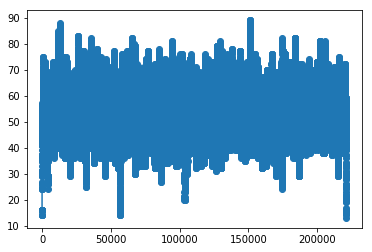

In [25]:
# Plot with Seaborn
plt.plot( 'Position', 'Depth', data=df, marker='o')
plt.show()